# Solving Finite MDP on grid world using Dynamic Programming

### The aim of the gridworld is to get out as soon as possible...

With a -1 reward after each step the agent is implied to get out fast, as to maximize score. (minimize negative score)

In [4]:
"""Imports and utilities"""

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

def heatmap(x, title=''):
    fig, ax = plt.subplots(figsize=(7,7))
    ax.matshow(x)
    for (i, j), z in np.ndenumerate(x):
        ax.text(j, i, f'{z:0.2f}', ha='center', va='center')
    plt.gca().set_axis_off()
    plt.title(title)
    plt.show()

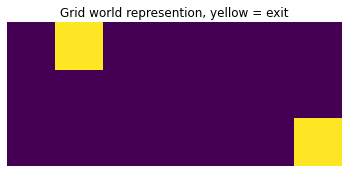

In [5]:
"""Environment and physics"""

y, x = (3, 7)
world = -np.ones((y, x)).astype(int)
world[0,1] = world[y-1, x-1] = 0

action_space = {
    0: (0,1),
    1: (1,0),
    2: (0,-1),
    3: (-1,0)
}

direction = lambda p, a: (p[0]+a[0], p[1]+a[1])
is_legal = lambda m: (m[0]>=0 and m[0]<y) and (m[1]>=0 and m[1]<x)

plt.title("Grid world represention, yellow = exit")
plt.imshow(world)
plt.gca().set_axis_off();

# Policies

The first policy below results in a biased selection of the first argmax from the states list.

Second policy returns the list of max actions, this list can be used in the Bellman equation:
- Summation over all prime states
- Calculate probability based on $\frac{1}{length}$ 

In [87]:
def greedy_policy(s) -> int:
    """ Simply returns the first greedy action from list of actions """
    actions = [direction(s, a) for a in action_space.values()]
    return np.argmax([state_value[s_ if is_legal(s_) else s] for s_ in actions])

def greedy_policy_lst(s) -> [int]:
    """ Returns the random selected greedy action and the number of options for probability calc. """
    actions = [direction(s, a) for a in action_space.values()]
    rewards = [(i, state_value[s_ if is_legal(s_) else s]) for i, s_ in enumerate(actions)]
    max_ = max(rewards, key=lambda k: k[1])[1]
    return list(zip(*filter(lambda f: f[1]==max_, rewards)))[0]

# Iterative Policy Evaluation, for estimating $V\approx v_\pi$

$V(s) = \sum_{a}\pi(a|s) \sum_{s',r}p(s',r|s,a)[r+\gamma V(s')]$

$\pi(a|s) = \frac{1}{4}$ -> `1/len(action_space)`

$p(s',r|s,a) = 1$ -> deterministic action

Therefore $\sum_{s',r}$ is collapsed to single iteration

$r = -1$ -> base rule states every move results in -1

Which brings us to:
$V(s) = \sum_{a}\frac{-1+V(s')}{4}$

This is random policy, corners are bad places: 
- $\frac{1}{2}$ moves results in -1 but same state

Optimal policy reached after 744 iterations.


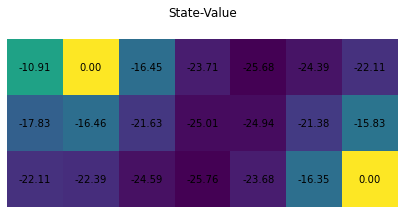

In [88]:
state_value = np.zeros_like(world).astype(float)

idx = 0
while True:
    delta = []
    state_value_ = np.copy(state_value)
    for s, val in np.ndenumerate(world):
        if val == 0: continue
        actions = [direction(s, a) for a in action_space.values()]
        state_value_[s] = sum([
            0.25 * (-1 + state_value[s_ if is_legal(s_) else s])
            for s_ in actions
        ])        
        delta.append(np.abs(state_value[s] -state_value_[s]))
        
    idx += 1
    state_value = state_value_
    if np.mean(delta) < 1e-20: break
        
print(f"Optimal policy reached after {idx} iterations.")
heatmap(state_value, "State-Value")

# Policy Iteration (using iterative policy evaluation) for estimating $\pi\approx\pi_*$

$V(s) = \sum_{s',r} p(s',r|s,\pi(s))[r+\gamma V(s')]$

$p(s',r|s,\pi(s)) = \frac{1}{n}$ given n = number of greedy actions



$\pi(s) = argmax_a\sum_{s',r} p(s',r|s,a)[r+\gamma V(s')]$



Optimal Policy reached after 4 iterations


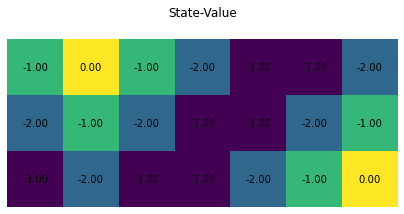

In [89]:
state_value = np.zeros_like(world).astype(float)

while True:
    idx = 0
    while True:
        delta = []
        state_value_ = np.copy(state_value)
        for s, val in np.ndenumerate(world):
            if val == 0: continue
            actions = greedy_policy_lst(s)
            states = list(map(lambda a: direction(s, action_space[a]), actions))
            state_value_[s] = sum([
                (1/len(actions)) * (-1 + state_value[s_ if is_legal(s_) else s])
                for s_ in states
            ])
            delta.append(np.abs(state_value[s] -state_value_[s]))
            
        idx += 1
        state_value = state_value_
        if np.mean(delta) < 1e-20: break

    stable = True
    for s, val in np.ndenumerate(world):
        a_curr = greedy_policy(s)
        actions = [direction(s, a) for a in action_space.values()]
        a = np.argmax([-1 + state_value[s_ if is_legal(s_) else s] for s_ in actions])
        if a_curr != a:
            stable = False
            
    print("Optimal" if stable else "Sub-optimal", f"Policy reached after {idx} iterations")
    heatmap(state_value, "State-Value")
    if stable: break

During my initial mockup of this algorithm I mistook $p(s',r|s,\pi(s))=1$ assuming $a=\pi(s)$ was already decided.

This led to the discovery that omitting the summation $\sum_{s',r}$ resulted in the same state-value mapping.

Since the reward is static $\sum_{s',r} \frac{1}{n}[r+\gamma V(s')]$ in this case works out to be $r+\gamma V(s')$.


Optimal Policy reached after 4 iterations


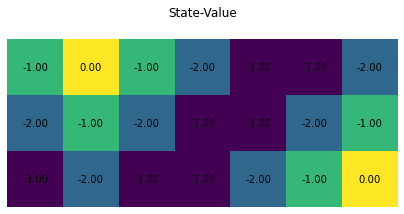

In [90]:
state_value = np.zeros_like(world).astype(float)

while True:
    idx = 0
    while True:
        delta = []
        state_value_ = np.copy(state_value)
        for s, val in np.ndenumerate(world):
            if val == 0: continue
            a = greedy_policy(s)
            s_ = direction(s, action_space[a])
            state_value_[s] = -1 + state_value[s_ if is_legal(s_) else s]
            delta.append(np.abs(state_value[s] -state_value_[s]))
            
        idx += 1
        state_value = state_value_
        if np.mean(delta) < 1e-20: break

    stable = True
    for s, val in np.ndenumerate(world):
        a_curr = greedy_policy(s)
        actions = [direction(s, a) for a in action_space.values()]
        a = np.argmax([-1 + state_value[s_ if is_legal(s_) else s] for s_ in actions])
        if a_curr != a: stable = False
    
    print("Optimal" if stable else "Sub-optimal", f"Policy reached after {idx} iterations")
    heatmap(state_value, "State-Value")
    if stable: break

# Value Iteration, for estimating $\pi\approx\pi_*$

$v_{k+1}(s)=max_a \sum_{s',r}p(s',r|s,a)[r+\gamma v_k(s)]$

Optimal policy reached after 4 iterations.


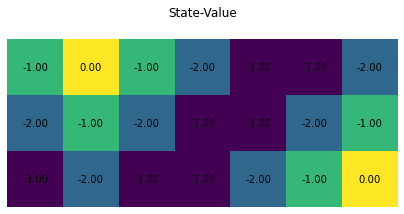

In [6]:
state_value = np.zeros_like(world).astype(float)

idx = 0
while True:
    delta = []
    state_value_ = np.copy(state_value)
    for s, val in np.ndenumerate(world):
        if val == 0: continue
        actions = [direction(s, a) for a in action_space.values()]
        state_value_[s] = max([-1 + state_value[s_ if is_legal(s_) else s] for s_ in actions])
        delta.append(np.abs(state_value[s] -state_value_[s]))

    idx += 1
    state_value = state_value_
    if np.mean(delta) < 1e-20: break

print(f"Optimal policy reached after {idx} iterations.")
heatmap(state_value, "State-Value")